# Intro
During the Boston Dragon Boat Festival of 2019, there were approximately 75 teams, with 4 teams racing at a time together along a 500 m race course (around 2-3 minutes to complete).

Each team raced a total of 3 times during the day for quarterfinals/semifinals/finals rounds.

Quarterfinal rounds place teams into divisions for the semifinal rounds (12 teams per division), then semifinal rounds place teams into categories within the divisions for the final rounds (top 4 teams = Major, next 4 teams = Minor, final 4 teams = tail).

Based on the data, can we determine:
+ Are there particular lanes that are better than others (teams consistently doing worse in a particular lane, possibly due to shallow waters or higher currents)?
+ Are there any particular races that are significantly more or less favorable for the teams (for example, due to higher wind and current)?

Data was obtained and reorganized based on: https://docs.google.com/spreadsheets/d/e/2PACX-1vR5avEH64BpkbvjiDU5Mpo-R--d6JELbh3eITSMjSCHLW2lZezcC3SoRXNFp2PxmA/pubhtml#

In [81]:
# Import necessary packages
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load and clean data

In [4]:
## Load and organize data
bostondb = pd.read_csv('Boston2019_Sunday_results.csv')

## Add column that specifies which round (quarterfinals/semifinals/finals) the races were
# Races 1-20 were quarterfinals, 21-39 were semifinals, and 40-58 were finals
round_conditions = [bostondb['Race'] < 21, (bostondb['Race'] > 20) & (bostondb['Race'] < 40), bostondb['Race'] > 39]
round_choices = ['Quarter', 'Semi', 'Finals']
bostondb['Round'] = np.select(round_conditions, round_choices, default='Other')

## Remove forfeited times
# Remove 0:00:00, 4:00:00, and 5:00:00 times since those were forfeited
bostondb = bostondb[(bostondb.Time != '00:00.000') & (bostondb.Time != '04:00.000') & (bostondb.Time != '05:00.000')]

# Remove outlier of 3:11.2 from Wellington Management Four Seas - Team 2, who dropped out after quarterfinals
bostondb = bostondb[bostondb.Team != 'Wellington Management Four Seas - Team 2']

## Add divisions
# Add column that specifies which division based on semifinals seedings
division_conditions = [bostondb['Race'].isin([37, 38, 39]),
                       bostondb['Race'].isin([34, 35, 36]),
                       bostondb['Race'].isin([31, 32, 33]),
                       bostondb['Race'].isin([28, 29, 30]),
                       bostondb['Race'].isin([25, 26, 27]),
                       bostondb['Race'].isin([21, 22, 23, 24])]
division_choices = ['A', 'B', 'C', 'D', 'E', 'F']
bostondb['Division'] = np.select(division_conditions, division_choices, default='Other')

for iTeam in bostondb.Team.unique():
    temp = bostondb['Division'][(bostondb.Team == iTeam) & (bostondb.Round == 'Semi')].values
    bostondb.loc[(bostondb.Team == iTeam), 'Division'] = temp

## Correct datatypes
# Examine datatypes of entries
bostondb.dtypes

# Change the datatype of Team, Round, and Division to 'category'
bostondb[['Team', 'Round', 'Division']] = bostondb[['Team', 'Round', 'Division']].astype('category')

# Change the datatype of Time to datetime (need to add 00: for hours first)
bostondb['Time'] = pd.to_timedelta('00:' + bostondb['Time'].astype(str))

# Change order of dataframe
bostondb = bostondb[['Race', 'Team', 'Time', 'Place', 'Lane', 'Round', 'Division']]

# Check the data
print(bostondb.head())
print(bostondb.tail())

   Race                                      Team            Time  Place  \
0     1                 Wellness Warriors Thunder 00:02:42.425000      1   
1     1   Chinese American BioMedical Association 00:02:45.677000      2   
3     2  Wellington Management Four Seas - Team 1 00:02:36.045000      1   
4     2                              Dragon Divas 00:02:40.435000      2   
5     2                  Bank of America Red Tide 00:02:48.472000      3   

   Lane    Round Division  
0     3  Quarter        F  
1     2  Quarter        F  
3     3  Quarter        F  
4     2  Quarter        F  
5     1  Quarter        F  
     Race                         Team            Time  Place  Lane   Round  \
220    57       Metro Athletic Dragons 00:02:11.997000      4     3  Finals   
221    58          CYPN Storm Instinct 00:01:59.191000      1     3  Finals   
222    58  Boston One Dragon Boat Team 00:02:00.010000      2     2  Finals   
223    58             Living Root Blue 00:02:00.565000     

# Data Visualization
Let us first examine the overall distribution of the data to confirm that it is mainly normally distributed and there are no remaining outliers.

Times according to division were also comapared as a sanity check that everything is in order.

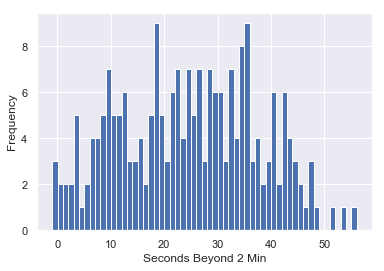

In [6]:
## Visualize the distribution of times
# Time in minutes and seconds
bostondb['Minutes'] = bostondb.Time / pd.Timedelta(minutes=1)
bostondb['Seconds'] = (bostondb.Time - pd.Timedelta(minutes=2)) / pd.Timedelta(seconds=1)

# Create a histogram to visualize distribution of times in seconds
bostondb.Seconds.plot(kind='hist', bins=np.arange(min(bostondb.Seconds), max(bostondb.Seconds) + 1, 1))
plt.xlabel('Seconds Beyond 2 Min')
plt.show()

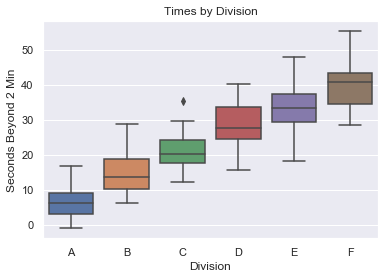

In [7]:
## Boxplot of times according to division
sns.boxplot(x='Division', y='Seconds', data=bostondb)
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Times by Division')
plt.show()

# Does lane affect the times?
Times according to lane were then plotted to attempt to answer: Are the shallower lanes near the shore slower?

Teams in faster divisions should be more experienced and more consistent, so analysis was limited to data from Divisions A-D.

There appears to be a consistent trend where lane 3 is the fastest, while lanes 1 and 4 are the slowest (p-values of 0.03 and 0.04 respectively), with the difference being close to 5 seconds.

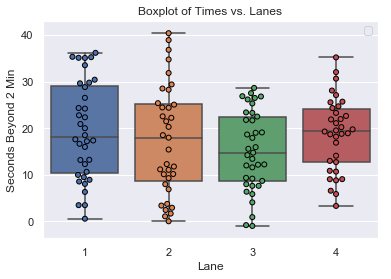

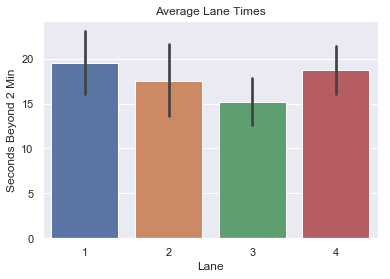

t-test for lanes  1  and  2 :  0.22718584777364303
t-test for lanes  1  and  3 :  0.029563749508532997
t-test for lanes  1  and  4 :  0.3747515879825466
t-test for lanes  2  and  3 :  0.1725504723317025
t-test for lanes  2  and  4 :  0.2996736845685906
t-test for lanes  3  and  4 :  0.035818785427797595


In [76]:
# Consider just Divisions A-D?
bostondbAD = bostondb[bostondb['Division'].isin(['A','B','C','D'])]

# Plot times according to lane
lane_means = bostondb.groupby(bostondbAD.Lane).Seconds.mean()

# Boxplot of times according to lane
sns.boxplot(x='Lane', y='Seconds', data=bostondbAD)
sns.swarmplot(x='Lane', y='Seconds', data=bostondbAD, dodge=True, edgecolor='black', linewidth=1)
plt.xlabel('Lane')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Boxplot of Times vs. Lanes')
plt.legend('')
plt.show()

# Bar plot of times according to lane
sns.barplot(x='Lane', y='Seconds', data=bostondbAD)
plt.xlabel('Lane')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Average Lane Times')
plt.show()

# Compute one-sided t-tests (alternative hypothesis is lane 3 is faster than lanes 1 and 4)
for i in np.arange(1,5):
    for j in np.arange(i+1,5):
        (t_stat, p_val) = ttest_ind(bostondbAD[bostondbAD['Lane']==i]['Seconds'],
                                    bostondbAD[bostondbAD['Lane']==j]['Seconds'])
        print('t-test for lanes ', i, ' and ', j, ': ', p_val/2)              

# Were the finals particularly (un)favorable for certain races?
Some apparent discrepancies between races appeared during the finals. For example, Division B averaged around 2:10-2:15 for most races, then in the final there was a race where the average time was 2:25.

Assuming teams perform similar over all the rounds, can we discern any races that were significantly more or less favorable for some teams (for example, due to higher wind and current)?

While the top 4 teams were faster for the finals compared to the quarterfinals, the difference was not quite statistically signficant (p-value = 0.07). On the other hand, for the next 8 teams, their times were on average 5 s slower going from the quarterfinals to the finals, and this difference was statistically significant (p-value = 0.01).

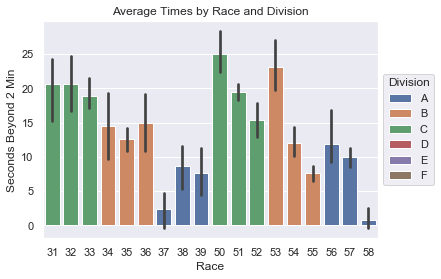

In [77]:
# Compare Division A-C semifinals and finals times
bostondbAC = bostondb[bostondb['Division'].isin(['A','B','C']) & bostondb['Round'].isin(['Semi','Finals'])]

# Bar plot of times according to race for each division
sns.barplot(x='Race', y='Seconds', data=bostondbAC, hue='Division', dodge=False)
plt.xlabel('Race')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Average Times by Race and Division')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Division')
plt.show()

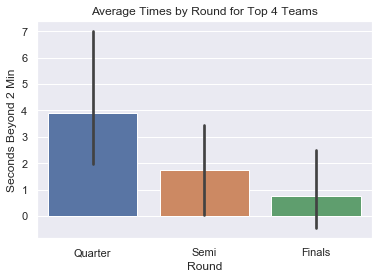

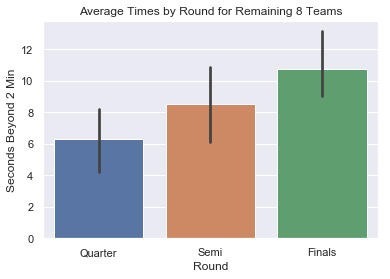

t-test for top 4 teams, quarterfinals vs. finals: 0.06741151541490294
t-test for top 4 teams, semifinals vs. finals: 0.25604194168689043
t-test for remaining 8 teams, quarterfinals vs. finals: 0.008893416265885397
t-test for remaining 8 teams, semifinals vs. finals: 0.11620944515216013


In [80]:
# Consider just the top 4 teams
bostondb['Round'].cat.reorder_categories(['Quarter', 'Semi', 'Finals'], inplace=True)
bostondbtop4 = bostondb[bostondb['Team'].isin(bostondb[bostondb['Race']==58]['Team'])]

# Bar plot of top 4 teams' times according to round
sns.barplot(x='Round', y='Seconds', data=bostondbtop4)
plt.xlabel('Round')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Average Times by Round for Top 4 Teams')
plt.show()

# Consider the remaining 8 teams
bostondb8to12 = bostondb[bostondb['Team'].isin(bostondb[bostondb['Race'].isin([56,57])]['Team'])]

# Bar plot of remaining 8 teams' times according to round
sns.barplot(x='Round', y='Seconds', data=bostondb8to12)
plt.xlabel('Round')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Average Times by Round for Remaining 8 Teams')
plt.show()

# Compute one-sided t-tests
(t_stat, p_val) = ttest_ind(bostondbtop4[bostondbtop4['Round']=='Quarter']['Seconds'],
                            bostondbtop4[bostondbtop4['Round']=='Finals']['Seconds'])
print('t-test for top 4 teams, quarterfinals vs. finals:', p_val/2)
(t_stat, p_val) = ttest_ind(bostondbtop4[bostondbtop4['Round']=='Semi']['Seconds'],
                bostondbtop4[bostondbtop4['Round']=='Finals']['Seconds'])
print('t-test for top 4 teams, semifinals vs. finals:', p_val/2)
(t_stat, p_val) = ttest_ind(bostondb8to12[bostondb8to12['Round']=='Quarter']['Seconds'],
                bostondb8to12[bostondb8to12['Round']=='Finals']['Seconds'])
print('t-test for remaining 8 teams, quarterfinals vs. finals:', p_val/2)
(t_stat, p_val) = ttest_ind(bostondb8to12[bostondb8to12['Round']=='Semi']['Seconds'],
                bostondb8to12[bostondb8to12['Round']=='Finals']['Seconds'])
print('t-test for remaining 8 teams, semifinals vs. finals:', p_val/2)

# Conclusions
+ There was about a 3-5 s advantage for being in lane 3 vs. lanes 1 and 4
+ There were likely disadvantageous conditions during the finals for teams 5 to 12 (5 s slower on average compared quarterfinals)
+ While the team in lane 3 won overall, the team in lane 1 lost by only 1.4 s, so they are the team to watch out for in future races
    + This team won the race the following weekend in Springfield

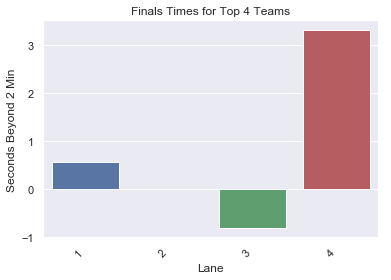

In [70]:
# Bar plot of times from final race
bostondbtop4['Team'].cat.remove_unused_categories(inplace=True)
sns.barplot(x='Lane', y='Seconds', data=bostondbtop4[bostondbtop4['Round']=='Finals'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Lane')
plt.ylabel('Seconds Beyond 2 Min')
plt.title('Finals Times for Top 4 Teams')
plt.show()